In [1]:
import mlflow
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from mlflow.models import infer_signature

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import max_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [2]:
# Start mlflow session
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")
mlflow.set_experiment("spaceflights-lab")
run = mlflow.start_run(run_name="__default__")

In [3]:
companies = pd.read_csv('../data/01_raw/companies.csv')
reviews = pd.read_csv('../data/01_raw/reviews.csv')
shuttles = pd.read_excel('../data/01_raw/shuttles.xlsx') 

In [4]:
print(companies.shape)
companies.head()

(10019, 5)


,id,company_rating,company_location,total_fleet_count,iata_approved
0,3888,100%,Isle of Man,1.0,f
1,46728,100%,NaN,1.0,f
2,34618,38%,Isle of Man,1.0,f
3,28619,100%,Bosnia and Herzegovina,1.0,f
4,8240,NaN,Chile,1.0,t


In [5]:
print(reviews.shape)
reviews.head()

(15531, 10)


,shuttle_id,review_scores_rating,review_scores_comfort,review_scores_amenities,review_scores_trip,review_scores_crew,review_scores_location,review_scores_price,number_of_reviews,reviews_per_month
0,45163,91.0,10.0,9.0,9.0,9.0,9.0,9.0,26,0.77
1,49438,96.0,10.0,10.0,10.0,10.0,10.0,9.0,61,0.62
2,10750,97.0,10.0,10.0,10.0,10.0,10.0,10.0,467,4.66
3,4146,95.0,10.0,10.0,10.0,10.0,9.0,9.0,318,3.22
4,5067,97.0,10.0,9.0,10.0,10.0,9.0,10.0,22,0.29


In [6]:
print(shuttles.shape)
shuttles.head()

(15531, 13)


,id,shuttle_location,shuttle_type,engine_type,engine_vendor,engines,passenger_capacity,cancellation_policy,crew,d_check_complete,moon_clearance_complete,price,company_id
0,45163,Sao Tome and Principe,Type V5,Plasma,ThetaBase Services,2.0,4,moderate,2.0,f,f,"$1,715.0",32413
1,49438,Wallis and Futuna,Type V2,Plasma,ThetaBase Services,3.0,5,moderate,3.0,f,f,"$3,405.0",14122
2,10750,Niue,Type F5,Quantum,ThetaBase Services,1.0,2,strict,1.0,t,f,"$1,806.0",47761
3,4146,Malta,Type V2,Quantum,ThetaBase Services,1.0,2,moderate,1.0,f,f,"$1,676.0",26648
4,5067,Malta,Type V2,Plasma,ThetaBase Services,5.0,10,strict,5.0,f,f,"$4,718.0",26648


In [7]:
# Data preparation
def _is_true(x: pd.Series) -> pd.Series:
    return x == "t"

def _parse_percentage(x: pd.Series) -> pd.Series:
    x = x.str.replace("%", "")
    x = x.astype(float) / 100
    return x

def _parse_money(x: pd.Series) -> pd.Series:
    x = x.str.replace("$", "").str.replace(",", "")
    x = x.astype(float)
    return x

companies["iata_approved"] = _is_true(companies["iata_approved"])
companies["company_rating"] = _parse_percentage(companies["company_rating"])

shuttles["d_check_complete"] = _is_true(shuttles["d_check_complete"])
shuttles["moon_clearance_complete"] = _is_true(shuttles["moon_clearance_complete"])
shuttles["price"] = _parse_money(shuttles["price"])

# Data merge
rated_shuttles = shuttles.merge(reviews, left_on="id", right_on="shuttle_id")
rated_shuttles = rated_shuttles.drop("id", axis=1)
model_input_table = rated_shuttles.merge(
    companies, left_on="company_id", right_on="id"
)
df = model_input_table.dropna()

In [8]:
df.head()

,shuttle_location,shuttle_type,engine_type,engine_vendor,engines,passenger_capacity,cancellation_policy,crew,d_check_complete,moon_clearance_complete,...,review_scores_crew,review_scores_location,review_scores_price,number_of_reviews,reviews_per_month,id,company_rating,company_location,total_fleet_count,iata_approved
0,Sao Tome and Principe,Type V5,Plasma,ThetaBase Services,2.0,4,moderate,2.0,False,False,...,9.0,9.0,9.0,26,0.77,32413,1.0,Faroe Islands,1.0,False
1,Wallis and Futuna,Type V2,Plasma,ThetaBase Services,3.0,5,moderate,3.0,False,False,...,10.0,10.0,9.0,61,0.62,14122,1.0,Malta,1.0,True
2,Niue,Type F5,Quantum,ThetaBase Services,1.0,2,strict,1.0,True,False,...,10.0,10.0,10.0,467,4.66,47761,1.0,Niue,2.0,False
3,Malta,Type V2,Quantum,ThetaBase Services,1.0,2,moderate,1.0,False,False,...,10.0,9.0,9.0,318,3.22,26648,1.0,Niue,2.0,True
4,Malta,Type V2,Plasma,ThetaBase Services,5.0,10,strict,5.0,False,False,...,10.0,9.0,10.0,22,0.29,26648,1.0,Niue,2.0,True


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6027 entries, 0 to 15265
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   shuttle_location         6027 non-null   object 
 1   shuttle_type             6027 non-null   object 
 2   engine_type              6027 non-null   object 
 3   engine_vendor            6027 non-null   object 
 4   engines                  6027 non-null   float64
 5   passenger_capacity       6027 non-null   int64  
 6   cancellation_policy      6027 non-null   object 
 7   crew                     6027 non-null   float64
 8   d_check_complete         6027 non-null   bool   
 9   moon_clearance_complete  6027 non-null   bool   
 10  price                    6027 non-null   float64
 11  company_id               6027 non-null   int64  
 12  shuttle_id               6027 non-null   int64  
 13  review_scores_rating     6027 non-null   float64
 14  review_scores_comfort    602

In [10]:
df.describe()

,engines,passenger_capacity,crew,price,company_id,shuttle_id,review_scores_rating,review_scores_comfort,review_scores_amenities,review_scores_trip,review_scores_crew,review_scores_location,review_scores_price,number_of_reviews,reviews_per_month,id,company_rating,total_fleet_count
count,6027.000000,6027.000000,6027.000000,6027.000000,6027.000000,6027.000000,6027.000000,6027.000000,6027.000000,6027.000000,6027.000000,6027.000000,6027.000000,6027.000000,6027.000000,6027.000000,6027.000000,6027.000000
mean,1.382943,3.416791,1.822466,2280.878547,24542.175709,38150.156629,92.161772,9.474199,9.277252,9.617388,9.645263,9.492119,9.215364,25.497760,1.577989,24542.175709,0.952801,18.296997
std,0.889904,2.048330,1.319141,1233.908183,14131.449537,22200.073840,9.664667,0.950548,1.070352,0.841555,0.846850,0.788481,0.983810,42.394413,1.597340,14131.449537,0.134595,41.483834
min,0.000000,1.000000,0.000000,870.000000,19.000000,30.000000,20.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,0.010000,19.000000,0.000000,1.000000
25%,1.000000,2.000000,1.000000,1520.000000,12598.000000,18719.500000,89.000000,9.000000,9.000000,9.000000,10.000000,9.000000,9.000000,4.000000,0.470000,12598.000000,0.990000,1.000000
50%,1.000000,3.000000,1.000000,1975.000000,24085.000000,38039.000000,95.000000,10.000000,10.000000,10.000000,10.000000,10.000000,9.000000,11.000000,1.030000,24085.000000,1.000000,3.000000
75%,2.000000,4.000000,2.000000,2670.500000,36716.000000,56839.000000,99.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,28.000000,2.090000,36716.000000,1.000000,12.000000
max,7.000000,20.000000,16.000000,19070.000000,50089.000000,77094.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,501.000000,16.560000,50089.000000,1.000000,420.000000


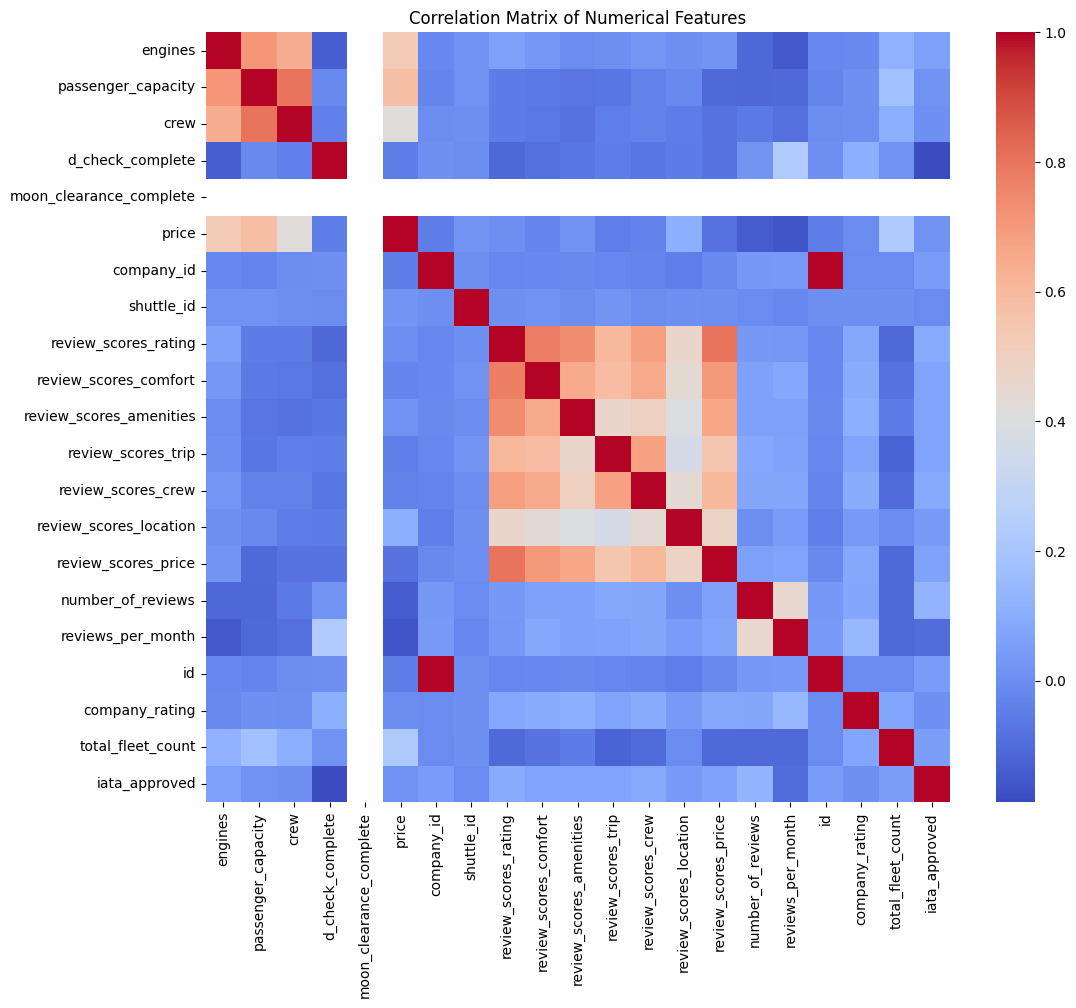

In [11]:
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(numeric_only=True), cmap="coolwarm")
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [12]:
# Define the full pipeline with a model
rf_params = {
    'n_estimators': 300,
    'max_depth': None,
    'min_samples_split': 5,
    'min_samples_leaf': 2,
    'max_features': 'sqrt',
    'random_state': 42,
    'n_jobs': -1
}

model = RandomForestRegressor(**rf_params)

In [13]:
# Eventually optimize model with cross validation
execute_cell = False

if execute_cell:
    # Define the hyperparameter grid (degree of the polynomial)
    param_grid = {
        'n_estimators': [10, 200],     # Number of trees
        'max_depth': [10, 200],    # Maximum depth of the tree
    }
    
    # GridSearchCV with 5-fold cross-validation to optimize the polynomial degree
    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2)
    
    # Fit the model
    grid_search.fit(X_train, y_train)
    
    # Best parameters
    print("Best Parameters: ", grid_search.best_params_)
    
    # Best model
    model = grid_search.best_estimator_

In [14]:
selected_cols = [
    'engines',
    'passenger_capacity',
    'crew',
    'd_check_complete',
    'moon_clearance_complete',
    'iata_approved',
    'company_rating',
    'review_scores_rating'
]

X = df[selected_cols]
y = df['price']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model.fit(X_train, y_train)

RandomForestRegressor(max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=5, n_estimators=300, n_jobs=-1,
                      random_state=42)

In [15]:
# Evaluate the model
y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)

print(f"r2: {r2}")
print(f"mae: {mae}")
print(f"rmse: {rmse}")

r2: 0.4063694665752271
mae: 550.952996808404
rmse: 979.5568935279603


In [16]:
# Save regressor params
mlflow.log_params(rf_params)

# Saves metrics
mlflow.log_metric("r2", r2)
mlflow.log_metric("mae", mae)
mlflow.log_metric("rmse", rmse)

# Set a tag that we can use to remind ourselves what this run was for
mlflow.set_tag("Training Info", "RandomForest model for spaceship data")

# Infer the model signature
signature = infer_signature(X_train, model.predict(X_train))

# Save regressor
model_info = mlflow.sklearn.log_model(
    sk_model=model,
    artifact_path="model",
    signature=signature,
    input_example=X_train,
    registered_model_name="spaceflights-pandas",
)

/home/nicola/.pyenv/versions/3.13.3/envs/mlflow/lib/python3.13/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Registered model 'spaceflights-pandas' already exists. Creating a new version of this model...
2025/05/12 23:41:32 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to 

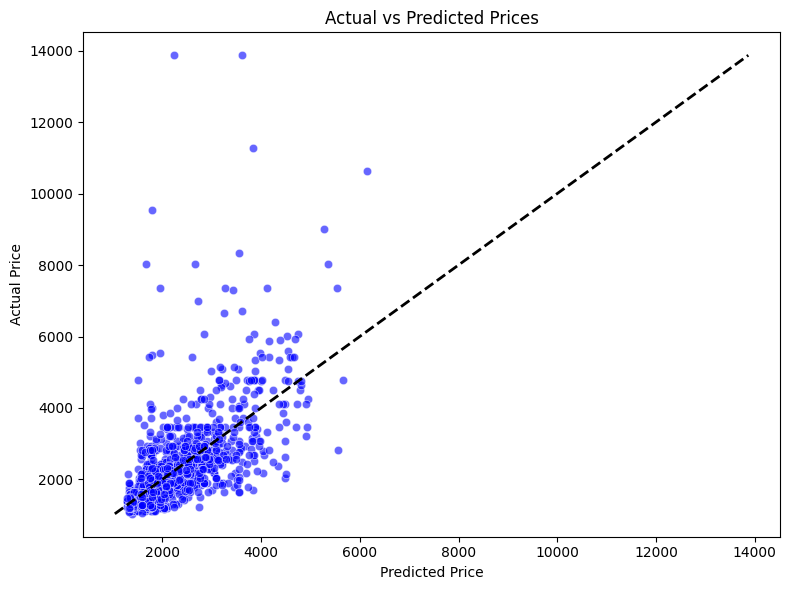

In [17]:
# Scatterplot: Actual vs Predicted
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=y_test, alpha=0.6, color='blue', ax=ax)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # 45-degree line
ax.set_xlabel('Predicted Price')
ax.set_ylabel('Actual Price')
ax.set_title('Actual vs Predicted Prices')
fig.tight_layout()

mlflow.log_figure(fig, "Scatterplot: Actual vs Predicted.png")

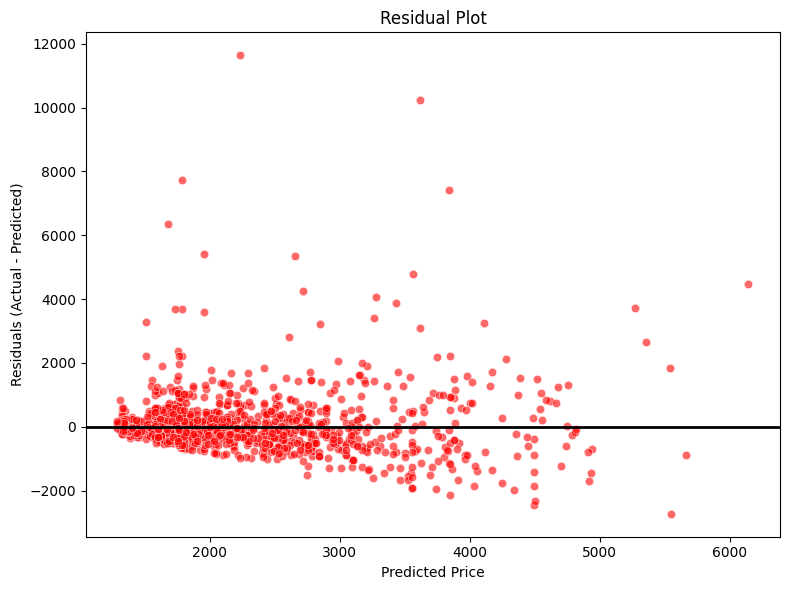

In [18]:
# Residual Plot: Actual vs Prediction Error
residuals = y_test - y_pred

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.6, color='red')
plt.axhline(0, color='black', lw=2)  # Line at y = 0
plt.xlabel('Predicted Price')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residual Plot')
plt.tight_layout()
plt.show()

mlflow.log_figure(fig, "Residual Plot: Actual vs Prediction Error.png")

/home/nicola/.pyenv/versions/3.13.3/envs/mlflow/lib/python3.13/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


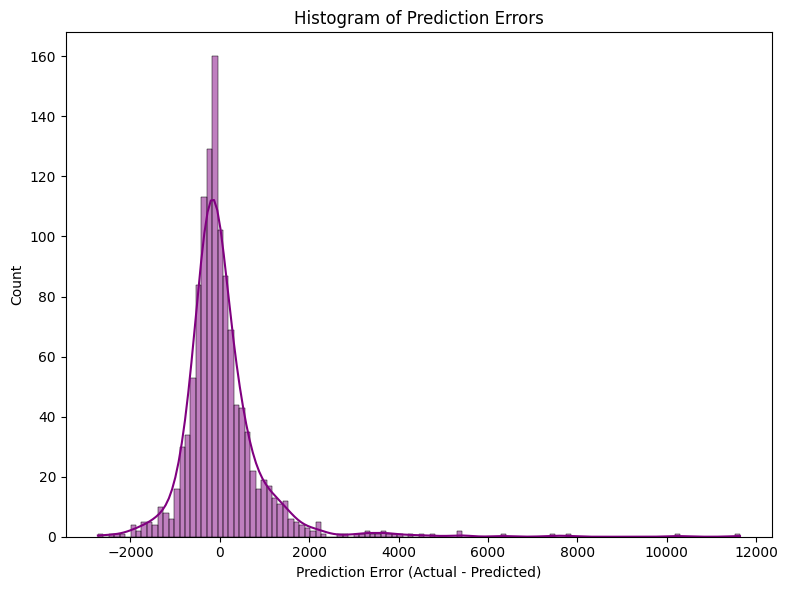

In [19]:
# Prediction Error Histogram
fig, ax = plt.subplots(figsize=(8, 6))
sns.histplot(residuals, kde=True, color='purple', ax=ax)
ax.set_xlabel('Prediction Error (Actual - Predicted)')
ax.set_title('Histogram of Prediction Errors')
fig.tight_layout()
plt.show()

mlflow.log_figure(fig, "Prediction Error Histogram.png")

In [20]:
# End mlflow session
mlflow.end_run()

🏃 View run __default__ at: http://127.0.0.1:5000/#/experiments/614456909848976914/runs/7ddc1cb866374a9a880edd96adda58af
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/614456909848976914
